# ML models approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, reciprocal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import uniform, loguniform

SEED = 2706

## Data preparation

First, we load the metadata file, which will allow us to work with each audio file.

In [2]:
features = pd.read_pickle("./features/ML_features.pickle")
features.tail()

,Emotion,Sex,Split,Augmented,Total_Spectrum_Power_mean,Total_Spectrum_Power_sd,Subband_Power_1_mean,Subband_Power_1_sd,Subband_Power_2_mean,Subband_Power_2_sd,...,Pitch_mean,Pitch_sd,Zero_crossing_rate_mean,Zero_crossing_rate_sd,MFCC_mean,MFCC_sd,Chromogram_mean,Chromogram_sd,Mel_spectrogram_mean,Mel_spectrogram_sd
24767,Disgust,Male,train,True,12.983054,1.411171,12.955716,1.402924,7.389684,2.351499,...,0.010917,0.004001,0.053099,0.023459,"[-156.59877, 109.69106, 45.973034, 28.950432, ...","[75.73071, 22.622038, 26.16163, 22.53711, 24.0...","[0.6312543, 0.79462963, 0.6587241, 0.5955665, ...","[0.15465811, 0.18367833, 0.18224716, 0.1723421...","[4.316952, 10.60315, 18.267727, 13.300422, 64....","[4.636136, 11.387119, 31.05826, 22.612993, 124..."
24768,Disgust,Male,train,True,13.026473,1.402174,13.000417,1.396788,7.464929,2.369535,...,0.010671,0.003881,0.052342,0.022798,"[-153.96979, 110.70275, 46.485016, 29.981018, ...","[75.3565, 22.298166, 25.853987, 22.357008, 23....","[0.65877986, 0.79978174, 0.672638, 0.6188865, ...","[0.15031634, 0.17549679, 0.17230497, 0.1735991...","[4.5061717, 11.067907, 23.141512, 16.848942, 6...","[4.8046055, 11.800908, 38.689854, 28.169424, 1..."
24769,Neutral,Female,train,False,12.695638,1.620216,12.355855,1.469623,7.743230,2.660121,...,0.011433,0.004133,0.159722,0.207278,"[-141.81468, 76.53104, 47.093967, 22.963186, 1...","[111.817924, 43.568146, 20.857653, 16.280832, ...","[0.67193735, 0.6883524, 0.622071, 0.6099142, 0...","[0.15896228, 0.20261477, 0.18680745, 0.1638436...","[3.4097817, 8.3749895, 13.071483, 9.517125, 22...","[3.38157, 8.305697, 14.0190525, 10.207035, 23...."
24770,Neutral,Female,train,True,12.520888,1.661272,12.224338,1.546494,7.555149,2.631477,...,0.011947,0.005180,0.160128,0.201883,"[-152.34631, 80.77296, 45.58678, 21.59728, 16....","[111.65119, 43.024757, 20.74987, 16.719913, 16...","[0.6944277, 0.6387099, 0.67223287, 0.657512, 0...","[0.21759664, 0.18722604, 0.19304463, 0.1819469...","[2.2828865, 5.6071477, 11.202599, 8.156422, 18...","[2.3193328, 5.6966662, 12.457814, 9.070323, 21..."
24771,Neutral,Female,train,True,12.703174,1.659977,12.341745,1.520947,7.800548,2.682455,...,0.011333,0.004569,0.173985,0.213438,"[-141.10448, 73.49956, 46.20085, 23.073511, 19...","[111.41144, 44.68909, 21.364582, 16.399576, 16...","[0.6623433, 0.6668284, 0.5970801, 0.5828214, 0...","[0.15324993, 0.19495104, 0.18217242, 0.1641396...","[3.186263, 7.8259907, 12.3545265, 8.995121, 22...","[3.1762977, 7.8015146, 13.774119, 10.028704, 2..."


We will treat the columns differently:
* Emotion is the target, so we will separate it. Since we are encountering a classification problem, we need numeric labels.
* Sex has to be casted as numeric.
* The mean and standard deviation columns have to be standardise, to eliminate changes in scale.
* The column of the MFCC needs to be unwinded.

There are some references that deemed that to compare fairly all columns, the computation of the sum of all variances of the group of means/sd and the unwinded columns to compute a ponderated sum helped. We, however, do not appreciate any effect with our data.

In [3]:
# -------------------------------
# 1. Separate target
# -------------------------------
target = features["Emotion"]
features = features.drop(columns=["Emotion"])

# Encode target labels
le = LabelEncoder()
target = le.fit_transform(target)

# -------------------------------
# 1. Mantener solo las columnas deseadas
# -------------------------------
selected_cols = [
    "Pitch_mean", "Pitch_sd",
    "Total_Spectrum_Power_mean", "Total_Spectrum_Power_sd",
    "Zero_crossing_rate_mean", "Zero_crossing_rate_sd",
    "Sex", "Split", "Augmented"
    #"Brightness_mean", "Brightness_sd",          # opcional
    #"Bandwidth_mean", "Bandwidth_sd"             # opcional
]

vec_cols = ["MFCC_mean", "MFCC_sd"]  # vectores que hay que expandir

# -------------------------------
# 2. Función para expandir columnas vectoriales
# -------------------------------
def expand_vector_cols(df, vec_cols):
    out = df.copy()
    for c in vec_cols:
        arr = np.stack(out[c].to_numpy())  # (N, n_mfcc)
        for i in range(arr.shape[1]):
            out[f"{c}_{i+1}"] = arr[:, i]
        out = out.drop(columns=c)
    return out

# -------------------------------
# 3. Filtrar y expandir
# -------------------------------
features = features[selected_cols + vec_cols].copy()
features = expand_vector_cols(features, vec_cols)

# -------------------------------
# 4. Convertir sexo a numérico
# -------------------------------
features["Sex"] = features["Sex"].map({"Male": 0, "Female": 1})

Before we standardise and ponderate, we have to separate between training and test data. Now, because we have augmented data we have to take care on how we separate the rows. This is because we need to test with real data to see the real performance.

In [4]:
# -------------------------------
# 4. Split using the `Split` column
# -------------------------------
X_train = features[features["Split"] == "train"].drop(columns=["Split", "Augmented"])
y_train = target[features["Split"] == "train"]

X_test = features[features["Split"] == "test"].drop(columns=["Split", "Augmented"])
y_test = target[features["Split"] == "test"]

Now we can freely apply the transformations.

In [5]:
cols_to_scale = X_train.columns.difference(["Sex"])

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

PCA is needed for SVM and kNN because we have too much features.

In [6]:
pca = PCA(n_components=0.95, svd_solver="full")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Dimensiones tras PCA:")
print("Train:", X_train_pca.shape)
print("Test:", X_test_pca.shape)

Dimensiones tras PCA:
Train: (22866, 18)
Test: (1906, 18)


The following code would be used for the case in which ponderated data is needed.

In [7]:
# # Standardise
# # Seleccionamos solo las columnas numéricas (salvo las excluidas)
# cols_to_scale = X_train.columns.difference(["Sex"] + mfcc_expanded.columns.to_list())

# scaler = StandardScaler()
# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# # Group variances
# # Agrupamos columnas según tipo
# means_sd_columns = [col for col in features.columns if "_mean" in col or "_sd" in col]
# mfcc_columns = [col for col in features.columns if "MFCC_" in col]

# # Suma de varianzas de cada grupo
# var_total_means_sd_train = X_train[means_sd_columns].std().sum()
# var_total_mfcc_train = X_train[mfcc_columns].std().sum()
# var_total_means_sd_test = X_test[means_sd_columns].std().sum()
# var_total_mfcc_test = X_test[mfcc_columns].std().sum()

In [8]:
# # Reconstruct the data
# # Normalización por suma de varianzas (ponderación)
# X_train.loc[:, means_sd_columns] = X_train[means_sd_columns] / var_total_means_sd_train
# X_train.loc[:, mfcc_columns] = X_train[mfcc_columns] / var_total_mfcc_train

# X_test.loc[:, means_sd_columns] = X_test[means_sd_columns] / var_total_means_sd_test
# X_test.loc[:, mfcc_columns] = X_test[mfcc_columns] / var_total_mfcc_test

## SVM

Let's start with SVM. This model needs PCA.

In [9]:
# SVM search space
param_distributions = {
    'svc__C': loguniform(0.1, 500),           # rango más amplio en escala log
    'svc__gamma': loguniform(1e-4, 0.05),     # gamma más pequeño para RBF
    'svc__kernel': ['rbf', 'poly'],                    # RBF suele funcionar mejor en SER
    'svc__class_weight': [None, 'balanced'],  # balancea clases si hay desbalance
    'svc__degree': [2,3,4]
}

# Alternativa si quieres probar sigmoid/poly, pero suele dar menos
# param_distributions['svc__kernel'] = ['rbf', 'poly']
# 

pipeline = Pipeline([
    ('svc', SVC())
])

# Instead of an usual grid, we try a stochastic search
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='accuracy',        # Accuracy is a good measure in this case
    cv=5,                      
    verbose=2,
    random_state=SEED,
    n_jobs=-1
)

In [10]:
search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('svc', SVC())]), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020DC9CA89A0>,
                                        'svc__class_weight': [None, 'balanced'],
                                        'svc__degree': [2, 3, 4],
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020DFF62E4D0>,
                                        'svc__kernel': ['rbf', 'poly']},
                   random_state=2706, scoring='accuracy', verbose=2)

Now we evaluate the performance in train and test. The procedure is the same for all models tried.

In [11]:
# Train report
labels = le.classes_  # Earlier labels
print(labels)
y_pred = search.predict(X_train_pca)
print(classification_report(y_train, y_pred))

['Angry' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Sad']
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      4047
           1       0.63      0.50      0.55      3852
           2       0.65      0.55      0.60      3906
           3       0.65      0.59      0.61      3912
           4       0.53      0.74      0.62      3258
           5       0.64      0.68      0.66      3891

    accuracy                           0.64     22866
   macro avg       0.64      0.64      0.64     22866
weighted avg       0.65      0.64      0.64     22866



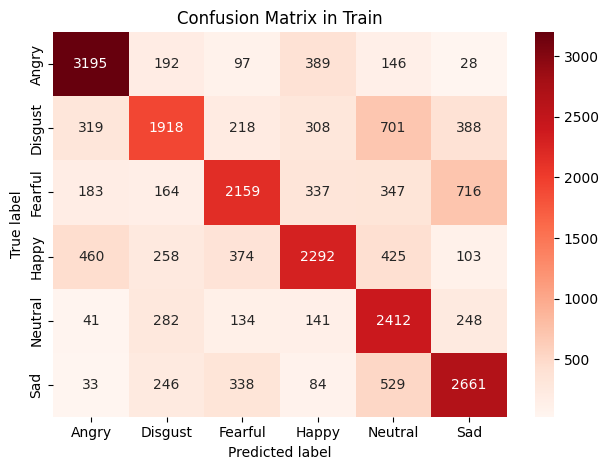

In [12]:
# Train confusion matrix
# Confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix in Train")
plt.tight_layout()
plt.show()

Now for test.

In [13]:
print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)

y_pred = search.predict(X_test_pca)
print(classification_report(y_test, y_pred))

Best parameters: {'svc__C': np.float64(10.994580122161372), 'svc__class_weight': 'balanced', 'svc__degree': 2, 'svc__gamma': np.float64(0.014349527467151972), 'svc__kernel': 'rbf'}
Best cross-validation score: 0.5218221608534571
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       337
           1       0.54      0.39      0.45       321
           2       0.54      0.40      0.46       326
           3       0.47      0.45      0.46       326
           4       0.42      0.58      0.49       272
           5       0.56      0.65      0.60       324

    accuracy                           0.53      1906
   macro avg       0.53      0.53      0.53      1906
weighted avg       0.54      0.53      0.53      1906



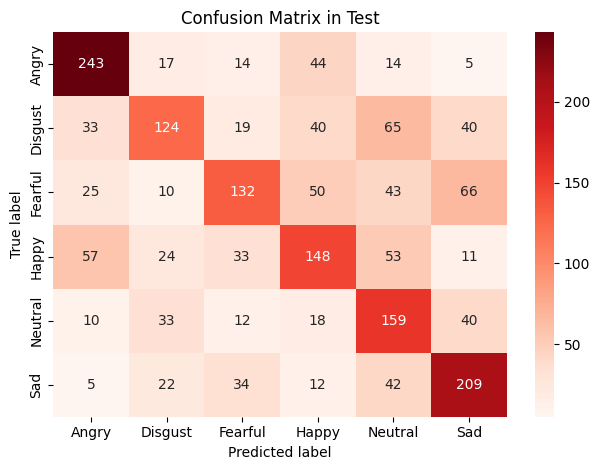

In [14]:
# 1. Predicted target
y_pred = search.predict(X_test_pca)

# 2. CM
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix in Test")
plt.tight_layout()
plt.show()

## k-Nearest Neighbours

Let's try a simpler model like kNN. It should not perform better but it is commonly use as a base model in some ML applications to audio classification.

In [15]:
# ----------------------------
# 1. Base model
# ----------------------------
knn = KNeighborsClassifier()

# ----------------------------
# 2. Search space
# ----------------------------
param_dist = {
    'n_neighbors': randint(1, 30),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# ----------------------------
# 3. Randomized Search
# ----------------------------
random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=30,  # puedes ajustar este número
    cv=5,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1
)

In [16]:
# Fit
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D8EF47CA0>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2706, scoring='accuracy')

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.74      4047
           1       0.62      0.48      0.54      3852
           2       0.65      0.50      0.57      3906
           3       0.60      0.56      0.58      3912
           4       0.55      0.69      0.61      3258
           5       0.62      0.68      0.65      3891

    accuracy                           0.62     22866
   macro avg       0.62      0.62      0.61     22866
weighted avg       0.62      0.62      0.62     22866



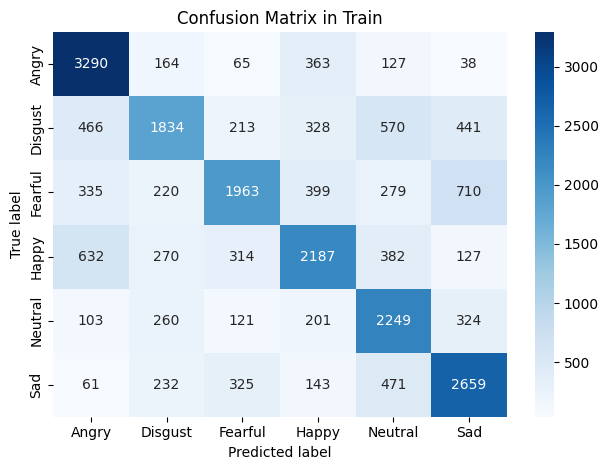

In [17]:
# ----------------------------
# 4.1 Evaluate in train set
# ----------------------------
y_pred = random_search.predict(X_train)

# Metrics
print("Classification Report:\n")
print(classification_report(y_train, y_pred))

# Confusion matrix
labels = le.classes_  

cm = confusion_matrix(y_train, y_pred)

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix in Train")
plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.74      0.66       337
           1       0.41      0.30      0.35       321
           2       0.50      0.34      0.40       326
           3       0.46      0.41      0.43       326
           4       0.40      0.51      0.45       272
           5       0.51      0.60      0.55       324

    accuracy                           0.49      1906
   macro avg       0.48      0.49      0.47      1906
weighted avg       0.48      0.49      0.48      1906



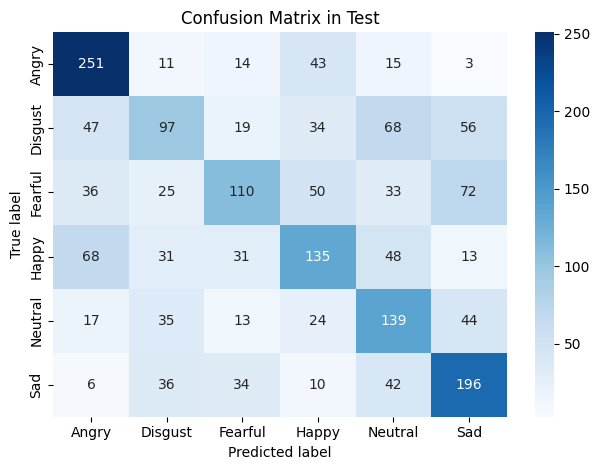

In [18]:
# ----------------------------
# 4.2 Evaluate in test set
# ----------------------------
y_pred = random_search.predict(X_test)

# Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix in Test")
plt.tight_layout()
plt.show()

## Random Forest

Finally, let's go for Random Forest. Opposed to SVM, this algorithm can be fed all data without much preprocessing.

In [19]:
features = pd.read_pickle("./features/ML_features.pickle")

# -------------------------------
# 1. Separate target
# -------------------------------
target = features["Emotion"]
features = features.drop(columns=["Emotion"])

# Encode target labels
le = LabelEncoder()
target = le.fit_transform(target)

# -------------------------------
# 1. Mantener solo las columnas deseadas
# -------------------------------
vec_cols = ["MFCC_mean", "MFCC_sd"]  # vectores que hay que expandir
features = features.drop(columns=["Chromogram_mean", "Chromogram_sd", "Mel_spectrogram_mean", "Mel_spectrogram_sd"])

# -------------------------------
# 2. Función para expandir columnas vectoriales
# -------------------------------
def expand_vector_cols(df, vec_cols):
    out = df.copy()
    for c in vec_cols:
        arr = np.stack(out[c].to_numpy())  # (N, n_mfcc)
        for i in range(arr.shape[1]):
            out[f"{c}_{i+1}"] = arr[:, i]
        out = out.drop(columns=c)
    return out

# -------------------------------
# 3. Filtrar y expandir
# -------------------------------
features = expand_vector_cols(features, vec_cols)

# -------------------------------
# 4. Convertir sexo a numérico
# -------------------------------
features["Sex"] = features["Sex"].map({"Male": 0, "Female": 1})

# -------------------------------
# 4. Split using the `Split` column
# -------------------------------
X_train = features[features["Split"] == "train"].drop(columns=["Split", "Augmented"])
y_train = target[features["Split"] == "train"]

X_test = features[features["Split"] == "test"].drop(columns=["Split", "Augmented"])
y_test = target[features["Split"] == "test"]

cols_to_scale = X_train.columns.difference(["Sex"])

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [20]:
# ----------------------------
# 1. Base model
# ----------------------------
rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

# ----------------------------
# 2. Search parameters (to avoid overfitting)
# ----------------------------
param_dist = {
    'n_estimators': randint(50, 150),              # less trees
    'max_depth': [5, 10, 20, None],                # less depth to avoid learning too much
    'min_samples_split': randint(4, 20),           # more samples to lower the size
    'min_samples_leaf': randint(2, 20),            # more samples to keep leaves simple
    'max_features': ['sqrt', 'log2'],              # less features to memorise
    'bootstrap': [True, False]                     
}

# ----------------------------
# 3. Randomized Search
# ----------------------------
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

In [21]:
# Fit
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=2706),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D8EF46260>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D8EF468F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D8EF455A0>},
                   random_state=2706, scoring='accuracy', verbose=1)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4047
           1       1.00      1.00      1.00      3852
           2       1.00      1.00      1.00      3906
           3       1.00      1.00      1.00      3912
           4       1.00      1.00      1.00      3258
           5       1.00      1.00      1.00      3891

    accuracy                           1.00     22866
   macro avg       1.00      1.00      1.00     22866
weighted avg       1.00      1.00      1.00     22866

['Angry' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Sad']


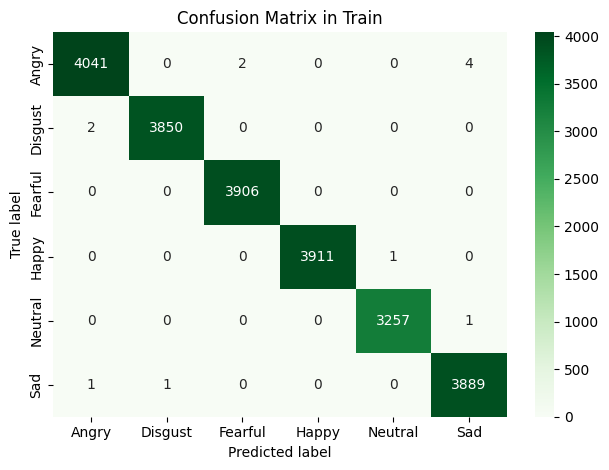

In [22]:
# ----------------------------
# 4.1 Evaluate in train set
# ----------------------------
y_pred = random_search.predict(X_train)

# Metrics
print("Classification Report:\n")
print(classification_report(y_train, y_pred))

# Confusion matrix
labels = le.classes_
cm = confusion_matrix(y_train, y_pred)
print(labels)

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix in Train")
plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       337
           1       0.52      0.40      0.45       321
           2       0.55      0.42      0.48       326
           3       0.49      0.47      0.48       326
           4       0.45      0.56      0.50       272
           5       0.56      0.64      0.59       324

    accuracy                           0.54      1906
   macro avg       0.54      0.54      0.53      1906
weighted avg       0.54      0.54      0.53      1906



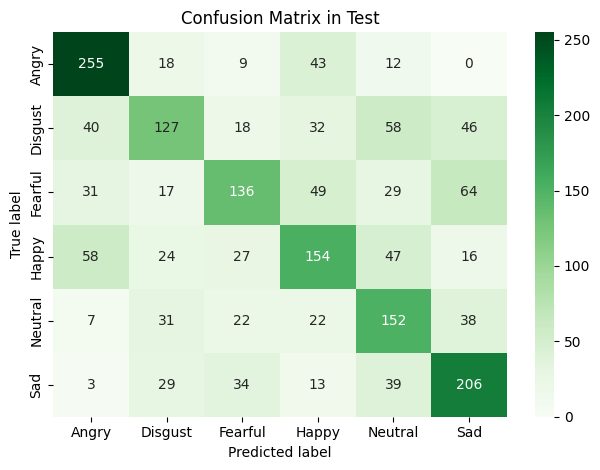

In [23]:
# ----------------------------
# 4.2 Evaluate in test set
# ----------------------------
y_pred = random_search.predict(X_test)

# Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix in Test")
plt.tight_layout()
plt.show()

All along, this models are not great. There are a few reasons why they underperform: wide range of origin for the audio recordings, not deep enough features or just that this kind of models are not adequate to the task.